In [1]:
import os
import matplotlib.pyplot as plt
import json

In [11]:
src_dir = "../results/maldonaldo62k/"
ori_name = "{}-satd-{}"
tesoro_name = "{}-tesoro-satd-{}"

methods = ["codebert-base", "roberta-base"]
method_names = ["CodeBERT", "RoBERTa"]
scenarios = ["identification", "classification", "detection"]


In [12]:
def read_rs(folder):
    projects = []
    f1 = []
    for proj in os.listdir(folder):
        if proj.startswith(("summary", "tesoro")):
            continue
        with open(os.path.join(folder, proj, f"{proj}_predict_score.json"), "r") as f:
            rs = json.load(f)
        
        if len(proj.split("-")) > 1:
            proj_name = "-".join(proj.split("-")[:-1])
        else:
            proj_name = proj
        projects.append(proj_name)
        # projects.append(proj)
        f1.append(rs["macro_f1"])
    return projects, f1

FileNotFoundError: [WinError 3] The system cannot find the path specified: '../results/maldonaldo62k/codebert-base-satd-identification'

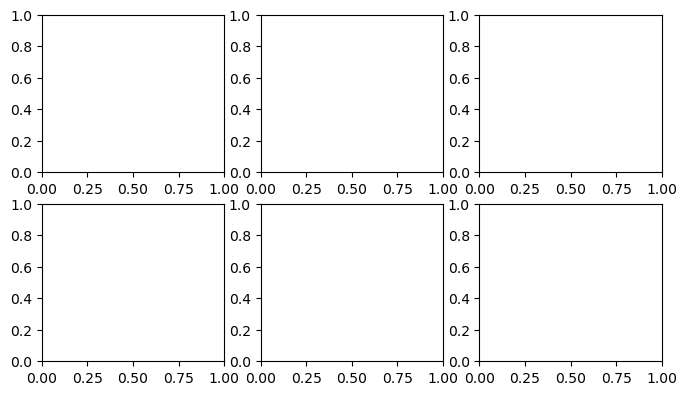

In [13]:
fig, axs = plt.subplots(2,3, figsize=(8,4.5))
for mid, method in enumerate(methods):

    for sid, scenario in enumerate(scenarios):
        ori_rs = read_rs(os.path.join(src_dir, ori_name.format(method, scenario)))
        tesoro_rs = read_rs(os.path.join(src_dir, tesoro_name.format(method, scenario)))
        axs[mid][sid].plot(ori_rs[0], ori_rs[1], color='orange', marker='o', label="Maldonado-62K")
        axs[mid][sid].plot(tesoro_rs[0], tesoro_rs[1], color='#4d4b72', marker='v', label="+Tesoro")

        if mid == 0:
            axs[mid][sid].set_xticks([])
            axs[mid][sid].set_title(scenario.capitalize(),fontsize=11)
        else:
            axs[mid][sid].set_xticklabels(ori_rs[0], rotation=90, fontsize=10)
        
        if sid == 0:
            axs[mid][sid].set_ylabel(method_names[mid],fontsize=11)

handles, labels = axs[0][0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncols=2, bbox_to_anchor=[0.5, 1.07], fontsize= 11)

plt.tight_layout()
# plt.show()
plt.savefig('figs/rq1_projects.pdf', bbox_inches='tight')